In [56]:
import time

import numpy as np
import tensorflow as tf

import re
from collections import Counter
from time import sleep
import json

import random

In [57]:
with open('pos_train.json') as json_data:
    d = json.load(json_data)

text=[]
l=0

for i in d:
    for j in i:
        for k in j:
            text.append(k)

tt = []
for i in range(len(text)):
    if(text[i]!=''):
        tt.append(text[i])

text = tt

for i in range(len(text)):
    if(text[i]=='$'or text[i]=='PDT' or text[i]=='WP$' or text[i]=="SYM" or text[i]=='LS' or text[i]=='#' or text[i]=='UH'):
        text[i]='OTHER'
    

word_counts = Counter(text)

word_counts.most_common()

[('NN', 391092),
 ('IN', 313428),
 ('NNP', 286327),
 ('DT', 246818),
 ('JJ', 194522),
 ('NNS', 150057),
 (',', 138811),
 ('.', 92716),
 ('CC', 86433),
 ('VBD', 83807),
 ('CD', 77651),
 ('RB', 71899),
 ('VBN', 69596),
 ('TO', 48800),
 ('VBZ', 41862),
 ('VB', 40118),
 ('VBG', 35283),
 (':', 34343),
 ('VBP', 28324),
 ('PRP', 24380),
 ('FW', 22213),
 ('PRP$', 18771),
 ('POS', 14923),
 ('WDT', 13756),
 ("''", 13344),
 ('``', 12561),
 ('MD', 11441),
 ('NNPS', 10637),
 ('JJS', 6400),
 ('JJR', 6373),
 ('WRB', 5119),
 ('WP', 4378),
 ('RP', 3189),
 ('RBR', 2910),
 ('OTHER', 2645),
 ('EX', 2623),
 ('RBS', 2274)]

In [4]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [5]:
words = text

print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

# vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Your code here
from collections import Counter
import random

threshold = 0.045
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

word_counts = Counter(train_words)

word_counts.most_common()

Total words: 2609824
Unique words: 37


[(0, 214218),
 (1, 191830),
 (2, 183019),
 (3, 170562),
 (4, 151288),
 (5, 132821),
 (6, 127626),
 (7, 92716),
 (8, 86433),
 (9, 83807),
 (10, 77651),
 (11, 71899),
 (12, 69596),
 (13, 48800),
 (14, 41862),
 (15, 40118),
 (16, 35283),
 (17, 34343),
 (18, 28324),
 (19, 24380),
 (20, 22213),
 (21, 18771),
 (22, 14923),
 (23, 13756),
 (24, 13344),
 (25, 12561),
 (26, 11441),
 (27, 10637),
 (28, 6400),
 (29, 6373),
 (30, 5119),
 (31, 4378),
 (32, 3189),
 (33, 2910),
 (34, 2645),
 (35, 2623),
 (36, 2274)]

In [6]:
len(train_words)

2060133

In [7]:
batch_size = 1000
window_size = 2
n_vocab = len(int_to_vocab)
n_embedding =  50

In [8]:
with tf.device('/device:GPU:1'):

    train_graph = tf.Graph()
    with train_graph.as_default():
        inputs = tf.placeholder(tf.int32, [None], name='inputs')
    #     labels = tf.placeholder(tf.int32, [None, None], name='labels')
        labels = tf.placeholder(tf.int32, [None, None], name='labels')
        
        embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
        embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output
        
        softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
        softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
        
        logits = tf.matmul(embed, tf.transpose(softmax_w)) + softmax_b
        labels_one_hot = tf.one_hot(labels, n_vocab)

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits)
        cost = tf.reduce_mean(loss)
        
        global_step = tf.Variable(0, trainable=False, name="global_step")

        optimizer = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)
        
         ## From Thushan Ganegedara's implementation
        valid_size = 16 # Random set of words to evaluate similarity on.
        valid_window = n_vocab
        # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
        valid_examples = np.array(random.sample(range(valid_window), valid_size))
#         valid_examples = np.append(valid_examples, 
#                                    random.sample(range(1000,1000+valid_window), valid_size//2))

        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        normalized_embedding = embedding / norm
        valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
        similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [9]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints/pos

mkdir: cannot create directory ‘checkpoints/pos’: File exists


In [10]:
# with train_graph.as_default():
#     saver = tf.train.Saver()
    
# with tf.Session(graph=train_graph) as sess:
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
#     embed_mat = sess.run(embedding)

In [11]:
epochs = 50

In [12]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints/pos'))
#     embed_mat = sess.run(embedding)
    
    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            global_steps, train_loss, _ = sess.run([global_step, cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100== 0: 
                end = time.time()
                print("Global Step: {}".format(global_steps), "Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
#             if iteration % 1000 == 0:
#                 ## From Thushan Ganegedara's implementation
#                 # note that this is expensive (~20% slowdown if computed every 500 steps)
#                 sim = similarity.eval()
#                 for i in range(valid_size):
#                     valid_word = int_to_vocab[valid_examples[i]]
#                     top_k = 8 # number of nearest neighbors
#                     nearest = (-sim[i, :]).argsort()[1:top_k+1]
#                     log = 'Nearest to %s:' % valid_word
#                     for k in range(top_k):
#                         close_word = int_to_vocab[nearest[k]]
#                         log = '%s %s,' % (log, close_word)
#                     print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/pos/pos.ckpt")
    embed_mat = sess.run(normalized_embedding)

Global Step: 100 Epoch 1/50 Iteration: 100 Avg. Training loss: 6.5519 0.0228 sec/batch
Global Step: 200 Epoch 1/50 Iteration: 200 Avg. Training loss: 4.8493 0.0128 sec/batch
Global Step: 300 Epoch 1/50 Iteration: 300 Avg. Training loss: 3.9669 0.0131 sec/batch
Global Step: 400 Epoch 1/50 Iteration: 400 Avg. Training loss: 3.5058 0.0153 sec/batch
Global Step: 500 Epoch 1/50 Iteration: 500 Avg. Training loss: 3.2970 0.0146 sec/batch
Global Step: 600 Epoch 1/50 Iteration: 600 Avg. Training loss: 3.1752 0.0150 sec/batch
Global Step: 700 Epoch 1/50 Iteration: 700 Avg. Training loss: 3.1270 0.0136 sec/batch
Global Step: 800 Epoch 1/50 Iteration: 800 Avg. Training loss: 3.0838 0.0124 sec/batch
Global Step: 900 Epoch 1/50 Iteration: 900 Avg. Training loss: 3.0234 0.0139 sec/batch
Global Step: 1000 Epoch 1/50 Iteration: 1000 Avg. Training loss: 3.0056 0.0129 sec/batch
Global Step: 1100 Epoch 1/50 Iteration: 1100 Avg. Training loss: 2.9958 0.0134 sec/batch
Global Step: 1200 Epoch 1/50 Iteration:

Global Step: 9400 Epoch 5/50 Iteration: 9400 Avg. Training loss: 2.9422 0.0139 sec/batch
Global Step: 9500 Epoch 5/50 Iteration: 9500 Avg. Training loss: 2.9602 0.0126 sec/batch
Global Step: 9600 Epoch 5/50 Iteration: 9600 Avg. Training loss: 2.9502 0.0126 sec/batch
Global Step: 9700 Epoch 5/50 Iteration: 9700 Avg. Training loss: 2.9484 0.0136 sec/batch
Global Step: 9800 Epoch 5/50 Iteration: 9800 Avg. Training loss: 2.9624 0.0141 sec/batch
Global Step: 9900 Epoch 5/50 Iteration: 9900 Avg. Training loss: 2.9592 0.0129 sec/batch
Global Step: 10000 Epoch 5/50 Iteration: 10000 Avg. Training loss: 2.9439 0.0140 sec/batch
Global Step: 10100 Epoch 5/50 Iteration: 10100 Avg. Training loss: 2.9280 0.0145 sec/batch
Global Step: 10200 Epoch 5/50 Iteration: 10200 Avg. Training loss: 2.9503 0.0132 sec/batch
Global Step: 10300 Epoch 5/50 Iteration: 10300 Avg. Training loss: 2.9406 0.0136 sec/batch
Global Step: 10400 Epoch 6/50 Iteration: 10400 Avg. Training loss: 2.9635 0.0152 sec/batch
Global Step

Global Step: 18500 Epoch 9/50 Iteration: 18500 Avg. Training loss: 2.9491 0.0073 sec/batch
Global Step: 18600 Epoch 10/50 Iteration: 18600 Avg. Training loss: 2.9538 0.0029 sec/batch
Global Step: 18700 Epoch 10/50 Iteration: 18700 Avg. Training loss: 2.9703 0.0051 sec/batch
Global Step: 18800 Epoch 10/50 Iteration: 18800 Avg. Training loss: 2.9642 0.0055 sec/batch
Global Step: 18900 Epoch 10/50 Iteration: 18900 Avg. Training loss: 2.9364 0.0063 sec/batch
Global Step: 19000 Epoch 10/50 Iteration: 19000 Avg. Training loss: 2.9453 0.0059 sec/batch
Global Step: 19100 Epoch 10/50 Iteration: 19100 Avg. Training loss: 2.9525 0.0047 sec/batch
Global Step: 19200 Epoch 10/50 Iteration: 19200 Avg. Training loss: 2.9486 0.0050 sec/batch
Global Step: 19300 Epoch 10/50 Iteration: 19300 Avg. Training loss: 2.9553 0.0054 sec/batch
Global Step: 19400 Epoch 10/50 Iteration: 19400 Avg. Training loss: 2.9456 0.0122 sec/batch
Global Step: 19500 Epoch 10/50 Iteration: 19500 Avg. Training loss: 2.9379 0.0146

Global Step: 27500 Epoch 14/50 Iteration: 27500 Avg. Training loss: 2.9547 0.0081 sec/batch
Global Step: 27600 Epoch 14/50 Iteration: 27600 Avg. Training loss: 2.9648 0.0140 sec/batch
Global Step: 27700 Epoch 14/50 Iteration: 27700 Avg. Training loss: 2.9291 0.0144 sec/batch
Global Step: 27800 Epoch 14/50 Iteration: 27800 Avg. Training loss: 2.9448 0.0130 sec/batch
Global Step: 27900 Epoch 14/50 Iteration: 27900 Avg. Training loss: 2.9541 0.0130 sec/batch
Global Step: 28000 Epoch 14/50 Iteration: 28000 Avg. Training loss: 2.9442 0.0130 sec/batch
Global Step: 28100 Epoch 14/50 Iteration: 28100 Avg. Training loss: 2.9560 0.0122 sec/batch
Global Step: 28200 Epoch 14/50 Iteration: 28200 Avg. Training loss: 2.9384 0.0130 sec/batch
Global Step: 28300 Epoch 14/50 Iteration: 28300 Avg. Training loss: 2.9679 0.0123 sec/batch
Global Step: 28400 Epoch 14/50 Iteration: 28400 Avg. Training loss: 2.9550 0.0129 sec/batch
Global Step: 28500 Epoch 14/50 Iteration: 28500 Avg. Training loss: 2.9639 0.013

Global Step: 36500 Epoch 18/50 Iteration: 36500 Avg. Training loss: 2.9511 0.0130 sec/batch
Global Step: 36600 Epoch 18/50 Iteration: 36600 Avg. Training loss: 2.9537 0.0135 sec/batch
Global Step: 36700 Epoch 18/50 Iteration: 36700 Avg. Training loss: 2.9702 0.0144 sec/batch
Global Step: 36800 Epoch 18/50 Iteration: 36800 Avg. Training loss: 2.9359 0.0129 sec/batch
Global Step: 36900 Epoch 18/50 Iteration: 36900 Avg. Training loss: 2.9287 0.0135 sec/batch
Global Step: 37000 Epoch 18/50 Iteration: 37000 Avg. Training loss: 2.9425 0.0150 sec/batch
Global Step: 37100 Epoch 19/50 Iteration: 37100 Avg. Training loss: 2.9518 0.0027 sec/batch
Global Step: 37200 Epoch 19/50 Iteration: 37200 Avg. Training loss: 2.9629 0.0121 sec/batch
Global Step: 37300 Epoch 19/50 Iteration: 37300 Avg. Training loss: 2.9716 0.0128 sec/batch
Global Step: 37400 Epoch 19/50 Iteration: 37400 Avg. Training loss: 2.9502 0.0134 sec/batch
Global Step: 37500 Epoch 19/50 Iteration: 37500 Avg. Training loss: 2.9479 0.013

Global Step: 45500 Epoch 23/50 Iteration: 45500 Avg. Training loss: 2.9850 0.0145 sec/batch
Global Step: 45600 Epoch 23/50 Iteration: 45600 Avg. Training loss: 2.9552 0.0146 sec/batch
Global Step: 45700 Epoch 23/50 Iteration: 45700 Avg. Training loss: 2.9413 0.0149 sec/batch
Global Step: 45800 Epoch 23/50 Iteration: 45800 Avg. Training loss: 2.9361 0.0125 sec/batch
Global Step: 45900 Epoch 23/50 Iteration: 45900 Avg. Training loss: 2.9488 0.0142 sec/batch
Global Step: 46000 Epoch 23/50 Iteration: 46000 Avg. Training loss: 2.9637 0.0137 sec/batch
Global Step: 46100 Epoch 23/50 Iteration: 46100 Avg. Training loss: 2.9521 0.0134 sec/batch
Global Step: 46200 Epoch 23/50 Iteration: 46200 Avg. Training loss: 2.9369 0.0151 sec/batch
Global Step: 46300 Epoch 23/50 Iteration: 46300 Avg. Training loss: 2.9356 0.0148 sec/batch
Global Step: 46400 Epoch 23/50 Iteration: 46400 Avg. Training loss: 2.9618 0.0139 sec/batch
Global Step: 46500 Epoch 23/50 Iteration: 46500 Avg. Training loss: 2.9473 0.013

Global Step: 54500 Epoch 27/50 Iteration: 54500 Avg. Training loss: 2.9391 0.0149 sec/batch
Global Step: 54600 Epoch 27/50 Iteration: 54600 Avg. Training loss: 2.9506 0.0127 sec/batch
Global Step: 54700 Epoch 27/50 Iteration: 54700 Avg. Training loss: 2.9433 0.0154 sec/batch
Global Step: 54800 Epoch 27/50 Iteration: 54800 Avg. Training loss: 2.9558 0.0140 sec/batch
Global Step: 54900 Epoch 27/50 Iteration: 54900 Avg. Training loss: 2.9492 0.0141 sec/batch
Global Step: 55000 Epoch 27/50 Iteration: 55000 Avg. Training loss: 2.9400 0.0145 sec/batch
Global Step: 55100 Epoch 27/50 Iteration: 55100 Avg. Training loss: 2.9689 0.0131 sec/batch
Global Step: 55200 Epoch 27/50 Iteration: 55200 Avg. Training loss: 2.9512 0.0140 sec/batch
Global Step: 55300 Epoch 27/50 Iteration: 55300 Avg. Training loss: 2.9563 0.0136 sec/batch
Global Step: 55400 Epoch 27/50 Iteration: 55400 Avg. Training loss: 2.9275 0.0139 sec/batch
Global Step: 55500 Epoch 27/50 Iteration: 55500 Avg. Training loss: 2.9413 0.014

Global Step: 63500 Epoch 31/50 Iteration: 63500 Avg. Training loss: 2.9645 0.0136 sec/batch
Global Step: 63600 Epoch 31/50 Iteration: 63600 Avg. Training loss: 2.9300 0.0139 sec/batch
Global Step: 63700 Epoch 31/50 Iteration: 63700 Avg. Training loss: 2.9344 0.0144 sec/batch
Global Step: 63800 Epoch 31/50 Iteration: 63800 Avg. Training loss: 2.9401 0.0144 sec/batch
Global Step: 63900 Epoch 32/50 Iteration: 63900 Avg. Training loss: 2.9553 0.0061 sec/batch
Global Step: 64000 Epoch 32/50 Iteration: 64000 Avg. Training loss: 2.9673 0.0144 sec/batch
Global Step: 64100 Epoch 32/50 Iteration: 64100 Avg. Training loss: 2.9695 0.0147 sec/batch
Global Step: 64200 Epoch 32/50 Iteration: 64200 Avg. Training loss: 2.9406 0.0155 sec/batch
Global Step: 64300 Epoch 32/50 Iteration: 64300 Avg. Training loss: 2.9433 0.0147 sec/batch
Global Step: 64400 Epoch 32/50 Iteration: 64400 Avg. Training loss: 2.9425 0.0140 sec/batch
Global Step: 64500 Epoch 32/50 Iteration: 64500 Avg. Training loss: 2.9532 0.014

Global Step: 72500 Epoch 36/50 Iteration: 72500 Avg. Training loss: 2.9423 0.0125 sec/batch
Global Step: 72600 Epoch 36/50 Iteration: 72600 Avg. Training loss: 2.9416 0.0140 sec/batch
Global Step: 72700 Epoch 36/50 Iteration: 72700 Avg. Training loss: 2.9425 0.0142 sec/batch
Global Step: 72800 Epoch 36/50 Iteration: 72800 Avg. Training loss: 2.9609 0.0154 sec/batch
Global Step: 72900 Epoch 36/50 Iteration: 72900 Avg. Training loss: 2.9589 0.0136 sec/batch
Global Step: 73000 Epoch 36/50 Iteration: 73000 Avg. Training loss: 2.9371 0.0143 sec/batch
Global Step: 73100 Epoch 36/50 Iteration: 73100 Avg. Training loss: 2.9431 0.0135 sec/batch
Global Step: 73200 Epoch 36/50 Iteration: 73200 Avg. Training loss: 2.9419 0.0138 sec/batch
Global Step: 73300 Epoch 36/50 Iteration: 73300 Avg. Training loss: 2.9541 0.0132 sec/batch
Global Step: 73400 Epoch 36/50 Iteration: 73400 Avg. Training loss: 2.9496 0.0147 sec/batch
Global Step: 73500 Epoch 36/50 Iteration: 73500 Avg. Training loss: 2.9383 0.015

Global Step: 81500 Epoch 40/50 Iteration: 81500 Avg. Training loss: 2.9416 0.0149 sec/batch
Global Step: 81600 Epoch 40/50 Iteration: 81600 Avg. Training loss: 2.9573 0.0135 sec/batch
Global Step: 81700 Epoch 40/50 Iteration: 81700 Avg. Training loss: 2.9498 0.0146 sec/batch
Global Step: 81800 Epoch 40/50 Iteration: 81800 Avg. Training loss: 2.9447 0.0140 sec/batch
Global Step: 81900 Epoch 40/50 Iteration: 81900 Avg. Training loss: 2.9598 0.0137 sec/batch
Global Step: 82000 Epoch 40/50 Iteration: 82000 Avg. Training loss: 2.9589 0.0120 sec/batch
Global Step: 82100 Epoch 40/50 Iteration: 82100 Avg. Training loss: 2.9421 0.0155 sec/batch
Global Step: 82200 Epoch 40/50 Iteration: 82200 Avg. Training loss: 2.9257 0.0139 sec/batch
Global Step: 82300 Epoch 40/50 Iteration: 82300 Avg. Training loss: 2.9496 0.0133 sec/batch
Global Step: 82400 Epoch 40/50 Iteration: 82400 Avg. Training loss: 2.9406 0.0137 sec/batch
Global Step: 82500 Epoch 41/50 Iteration: 82500 Avg. Training loss: 2.9634 0.014

Global Step: 90500 Epoch 44/50 Iteration: 90500 Avg. Training loss: 2.9355 0.0152 sec/batch
Global Step: 90600 Epoch 44/50 Iteration: 90600 Avg. Training loss: 2.9490 0.0161 sec/batch
Global Step: 90700 Epoch 45/50 Iteration: 90700 Avg. Training loss: 2.9522 0.0087 sec/batch
Global Step: 90800 Epoch 45/50 Iteration: 90800 Avg. Training loss: 2.9700 0.0148 sec/batch
Global Step: 90900 Epoch 45/50 Iteration: 90900 Avg. Training loss: 2.9631 0.0143 sec/batch
Global Step: 91000 Epoch 45/50 Iteration: 91000 Avg. Training loss: 2.9349 0.0148 sec/batch
Global Step: 91100 Epoch 45/50 Iteration: 91100 Avg. Training loss: 2.9423 0.0139 sec/batch
Global Step: 91200 Epoch 45/50 Iteration: 91200 Avg. Training loss: 2.9494 0.0130 sec/batch
Global Step: 91300 Epoch 45/50 Iteration: 91300 Avg. Training loss: 2.9468 0.0125 sec/batch
Global Step: 91400 Epoch 45/50 Iteration: 91400 Avg. Training loss: 2.9535 0.0148 sec/batch
Global Step: 91500 Epoch 45/50 Iteration: 91500 Avg. Training loss: 2.9435 0.014

Global Step: 99500 Epoch 49/50 Iteration: 99500 Avg. Training loss: 2.9469 0.0152 sec/batch
Global Step: 99600 Epoch 49/50 Iteration: 99600 Avg. Training loss: 2.9533 0.0142 sec/batch
Global Step: 99700 Epoch 49/50 Iteration: 99700 Avg. Training loss: 2.9648 0.0150 sec/batch
Global Step: 99800 Epoch 49/50 Iteration: 99800 Avg. Training loss: 2.9302 0.0143 sec/batch
Global Step: 99900 Epoch 49/50 Iteration: 99900 Avg. Training loss: 2.9436 0.0155 sec/batch
Global Step: 100000 Epoch 49/50 Iteration: 100000 Avg. Training loss: 2.9532 0.0145 sec/batch
Global Step: 100100 Epoch 49/50 Iteration: 100100 Avg. Training loss: 2.9426 0.0138 sec/batch
Global Step: 100200 Epoch 49/50 Iteration: 100200 Avg. Training loss: 2.9550 0.0164 sec/batch
Global Step: 100300 Epoch 49/50 Iteration: 100300 Avg. Training loss: 2.9362 0.0141 sec/batch
Global Step: 100400 Epoch 49/50 Iteration: 100400 Avg. Training loss: 2.9667 0.0135 sec/batch
Global Step: 100500 Epoch 49/50 Iteration: 100500 Avg. Training loss: 

In [58]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/pos'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/pos/pos.ckpt


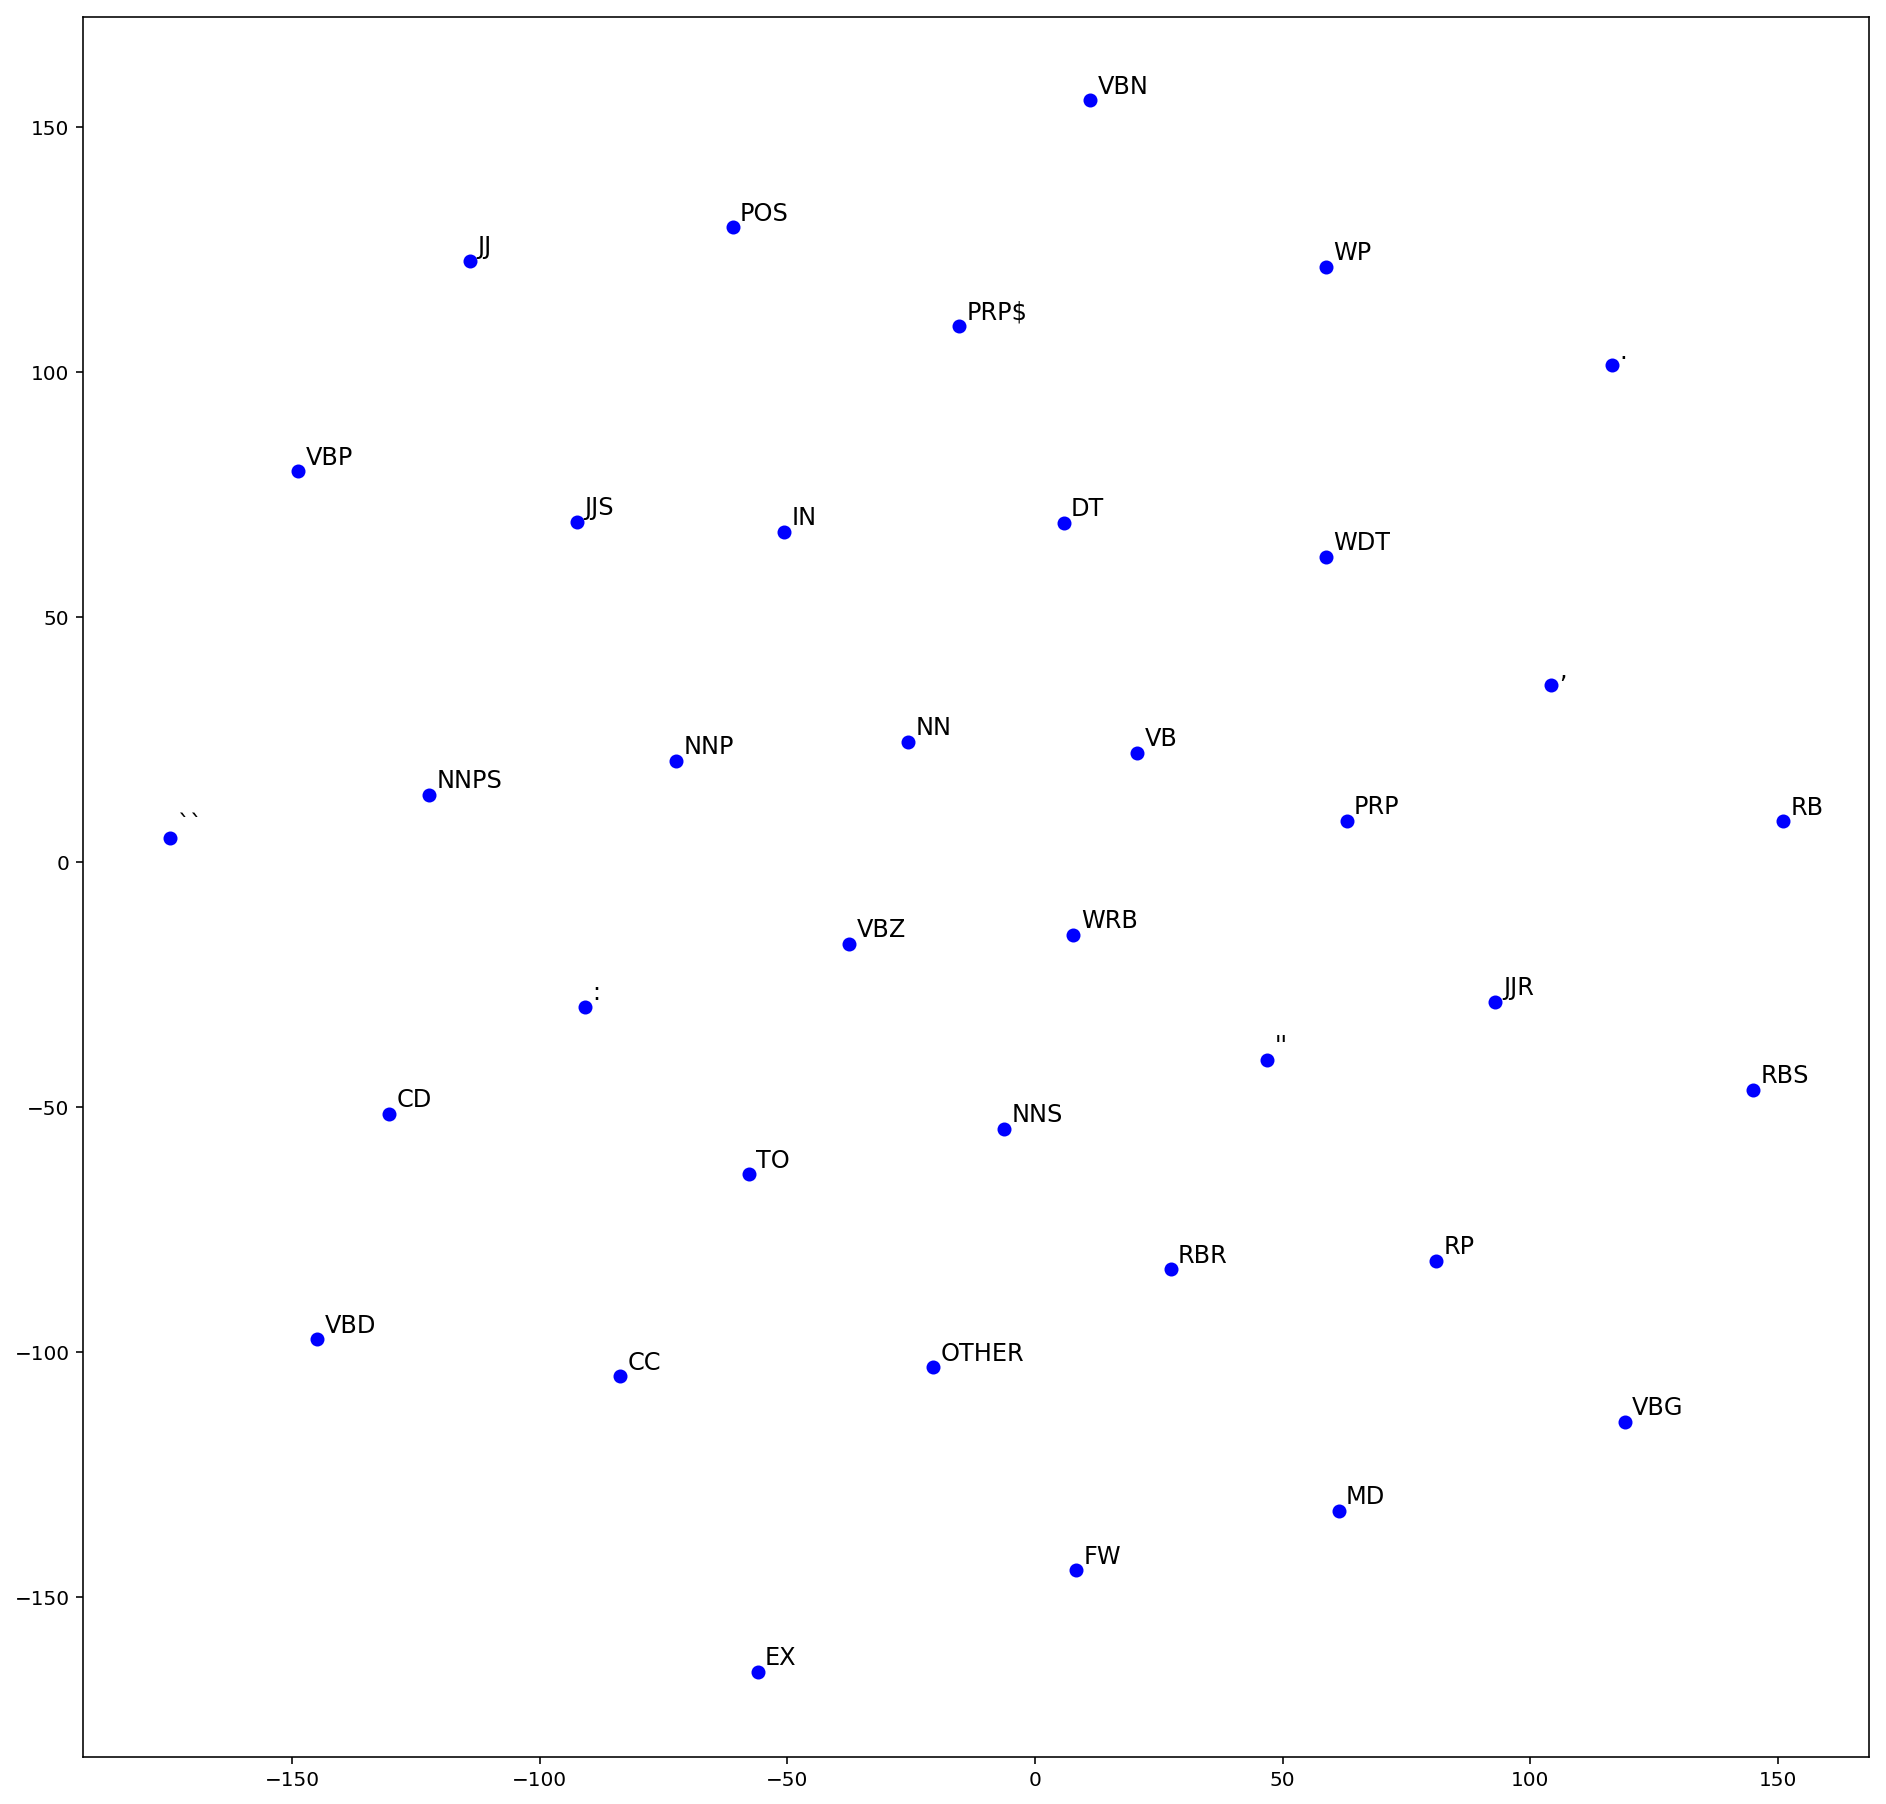

In [59]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = n_vocab
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1, xytext=(embed_tsne[idx, 0]+1.5, embed_tsne[idx, 1]+1.5), fontsize=12)